In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from matplotlib.lines import Line2D

## Load and Combine AUROC Output from multiple Experiments

The output from the AUROC calculation script generates four dataframes:
1. **Raw AUROC scores**: AUROC scores for each method, calculated across all edges
    * `pooled_auroc_auprc_raw_results.csv`
2. **Pooled AUROC scores**: AUROC scores for each method, aggregated by ground truth.
    * `pooled_auroc_auprc_results.csv`
3. **Per-TF AUROC scores**: Per-TF AUROC scores for each method, separated by ground truth.
    * `per_tf_auroc_auprc_results.csv`
4. **Per-TF AUROC Summary**: Summary statistics of the per-TF AUROC scores.
    * `per_tf_auroc_auprc_summery.csv`

In [27]:
def format_path(experiment_name: str, model_training_number: int) -> Path:
    """
    Reads in the AUROC results from a given experiment and model training number.
    
    Uses a fixed base directory.
    
    Parameters
    -------------
    experiment_name : str
        Name of the experiment (e.g., "K562_test_experiment")
    model_training_number : int
        Model training number (e.g. 1 for "model_training_001")
        
    Returns
    -------------
    Path
        Path to the experiment directory
    """
    base_dir = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments")
    exp_dir = base_dir / experiment_name / "chr19" / f"model_training_{model_training_number:03d}"
    return exp_dir

def read_exp_auroc_results(auroc_exp_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Docstring for read_exp_auroc_results
    
    Parameters
    -------------
    auroc_exp_dir : Path
        Path to the experiment directory containing AUROC results.
        
    Returns
    -------------
    tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]
        Tuple containing:
        - raw_results_df: DataFrame with raw AUROC and AUPRC results.
        - results_df: DataFrame with pooled AUROC and AUPRC results.
        - per_tf_all_df: DataFrame with per-TF AUROC and AUPRC results.
        - per_tf_summary_df: DataFrame with summary statistics of per-TF AUROC and AUPRC results.
    """
    raw_results_df = pd.read_csv(auroc_exp_dir / "pooled_auroc_auprc_raw_results.csv")
    results_df = pd.read_csv(auroc_exp_dir / "pooled_auroc_auprc_results.csv")
    per_tf_all_df = pd.read_csv(auroc_exp_dir / "per_tf_auroc_auprc_results.csv")
    per_tf_summary_df = pd.read_csv(auroc_exp_dir / "per_tf_auroc_auprc_summary.csv")
    
    return raw_results_df, results_df, per_tf_all_df, per_tf_summary_df

def load_and_combine_experiment_results(experiment_list: list[tuple[str, int]]) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Loads and combines AUROC results from multiple experiments.
    
    Parameters
    -------------
    experiment_list : list[tuple[str, int]]
        List of tuples containing experiment names and model training numbers.
        
    Returns
    -------------
    tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]
        Tuple containing combined results DataFrames:
        - combined_raw_results_df: DataFrame with raw pooled AUROC and AUPRC results.
        - combined_results_df: DataFrame with pooled AUROC and AUPRC results.
        - combined_per_tf_all_df: DataFrame with per-TF AUROC and AUPRC results.
        - combined_per_tf_summary_df: DataFrame with summary statistics of per-TF AUROC and AUPRC results.
    """
    combined_experiment_list = []
    for experiment_name, model_training_number in experiment_list:
        auroc_exp_dir = format_path(experiment_name, model_training_number)
        raw_results_df, results_df, per_tf_all_df, per_tf_summary_df = read_exp_auroc_results(auroc_exp_dir)
        
        raw_results_df["experiment"] = experiment_name
        results_df["experiment"] = experiment_name
        per_tf_all_df["experiment"] = experiment_name
        per_tf_summary_df["experiment"] = experiment_name
        
        combined_experiment_list.append((raw_results_df, results_df, per_tf_all_df, per_tf_summary_df))

    combined_raw_results_df = pd.concat([x[0] for x in combined_experiment_list], ignore_index=True)
    combined_results_df = pd.concat([x[1] for x in combined_experiment_list], ignore_index=True)
    combined_per_tf_all_df = pd.concat([x[2] for x in combined_experiment_list], ignore_index=True)
    combined_per_tf_summary_df = pd.concat([x[3] for x in combined_experiment_list], ignore_index=True)
    
    return combined_raw_results_df, combined_results_df, combined_per_tf_all_df, combined_per_tf_summary_df

In [148]:
mESC_E7_5_rep1_experiment_list = [
    ("mESC_two_hop_no_hvg_small", 2),
    # ("mES_two_hop_hvg_small", 1),
    # ("mESC_E7.5_rep1_hvg_filter_only_rna", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.01", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.05", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.1", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.2", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.3", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.4", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.5", 1),
    ("mESC_E7.5_rep1_hvg_filter_disp_0.6", 1),
]

mESC_E7_5_rep2_experiment_list = [
    # ("mESC_E7.5_rep2_hvg_filter_only_rna", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.01", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.05", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.1", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.2", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.3", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.4", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.5", 1),
    ("mESC_E7.5_rep2_hvg_filter_disp_0.6", 1),
]

mESC_multiple_sample_experiment_list = [
    ("mESC_1_sample_hvg_filter_disp_0.01", 1),
    ("mESC_2_sample_hvg_filter_disp_0.01", 1),
    ("mESC_3_sample_hvg_filter_disp_0.01", 1),
    ("mESC_4_sample_hvg_filter_disp_0.01", 1),
]


macrophage_buffer_1_experiment_list = [
    ("Macrophage_buffer_1_hvg_filter_only_rna", 2),
    ("Macrophage_buffer_1_hvg_filter_none", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.01", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.05", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.1", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.2", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.3", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.4", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.5", 2),
    ("Macrophage_buffer_1_hvg_filter_disp_0.6", 2),
]

macrophage_buffer_2_experiment_list = [
    # ("Macrophage_buffer_2_hvg_filter_only_rna", 1),
    ("Macrophage_buffer_2_hvg_filter_none", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.01", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.05", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.1", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.2", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.3", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.4", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.5", 1),
    ("Macrophage_buffer_2_hvg_filter_disp_0.6", 1),
]

macrophage_sample_num_experiment_list = [
    ("Macrophage_buffer_1_hvg_filter_disp_0.1", 2),
    ("Macrophage_buffer_12_hvg_filter_disp_0.1", 1),
    ("Macrophage_buffer_123_hvg_filter_disp_0.1", 1),
    ("Macrophage_buffer_1234_hvg_filter_disp_0.1", 1),
]

k562_experiment_list = [
    # ("K562_hvg_filter_only_rna", 1),
    ("K562_hvg_filter_none", 1),
    ("K562_hvg_filter_disp_0.01", 1),
    ("K562_hvg_filter_disp_0.05", 1),
    ("K562_hvg_filter_disp_0.1", 1),
    ("K562_hvg_filter_disp_0.2", 1),
    ("K562_hvg_filter_disp_0.3", 1),
    ("K562_hvg_filter_disp_0.4", 1),
    ("K562_hvg_filter_disp_0.5", 1),
    ("K562_hvg_filter_disp_0.6", 1),
]

loaded_combined_dfs = load_and_combine_experiment_results(macrophage_buffer_2_experiment_list)
combined_raw_results_df, combined_results_df, combined_per_tf_all_df, combined_per_tf_summary_df = loaded_combined_dfs

### Select Experiment for Individual Plots

In [30]:
selected_experiment = "mESC_1_sample_hvg_filter_disp_0.01"

## Single Experiment Plotting

### Lift Curves

These curves show how much greater the likelihood is of finding a true positive in the top k edges compared to randomly sampling the distribution. These plots demonstrate how well the model performs at scoring true positives with higher scores compared to the average positive rate across the full GRN. 

$$\text{Lift} = \frac{\text{Precision}}{\text{Positive Rate}}$$

Where:
  * $\text{Precision} = \frac{\text{True Positives in top K scores}}{\text{Number of K scores}}$
  * $\text{Positive Rate} = \frac{1}{N} \sum_{i=1}^{N}X_{i}$

This metric is comparable across different GRN inference methods and ground truth datasets, as it measures the enrichment of positive scores compared to negative scores within a GRN. These graphs are also easy to interpret, as it shows how likely you are to find a positive edge among the top k edge scores compared to randomly choosing an edge score from the entire distribution.

In [31]:
def lift_curve(y: np.ndarray, s: np.ndarray):
    """
    Compute lift@k for all k = 1..N.
    Returns:
        frac: fraction of predictions included
        lift: lift at each fraction
    """
    y = np.asarray(y)
    s = np.asarray(s)

    pos_rate = y.mean()
    if pos_rate == 0:
        return None, None

    # Sort the scores and labels by descending score
    order = np.argsort(s)[::-1]
    y_sorted = y[order]

    # Return the cumulative sum of true positives at each position
    tp = np.cumsum(y_sorted)
    k = np.arange(1, len(y_sorted) + 1)

    # Lift is the precision of the top k predictions divided by the overall positive rate
    precision = tp / k
    lift = precision / pos_rate
    frac = k / len(y_sorted)

    return frac, lift

def calculate_method_lift_curves(df: pd.DataFrame) -> dict[str, tuple[np.ndarray, np.ndarray]]:
    """
    Calculate lift curves for each method in the DataFrame.
    
    Parameters
    -------------
    df : pd.DataFrame
        DataFrame containing 'method', 'y_true', and 'y_scores' columns.
        
    Returns
    -------------
    dict[str, tuple[np.ndarray, np.ndarray]]
        Dictionary mapping method names to their corresponding (frac, lift) tuples.
    """
    method_lift_curves = {}
    for method in df['method'].unique():
        method_df = df[df['method'] == method]
        y_true = method_df['y_true'].values
        y_scores = method_df['y_scores'].values
        
        frac, lift = lift_curve(y_true, y_scores)
        method_lift_curves[method] = (frac, lift)
    
    return method_lift_curves

### AUROC Boxplots

We can compare the AUROC scores between GRN inference methods in three ways:

1. **Per-TF, aggregated across all ground truths**: This method shows the mean AUROC score for each TF, which shows how dependent the overall AUROC score is to individual transcription factors. Each data point represents one TF's average AUROC across all ground truth datasets.

2. **Per-TF, aggregated across all TFs**: This method takes averages the mean AUROC scores for all TF's per ground truth, showing if the per-TF average scores are affected by the ground truth. Each data point represents the method's average per-TF AUROC for one ground truth dataset.

3. **Pooled AUROC**: This method calculates the AUROC score for all TF-TG edges, without grouping by TF first. This method weights edge scores for TFs with many TGs equally to TFs with very few TGs. Each data point represents the AUROC for all edges of one ground truth.

#### Plotting Function

In [32]:
def plot_all_results_auroc_boxplot(
    df: pd.DataFrame, 
    per_tf: bool = False, 
    override_color: bool = False,
    ylim: tuple = (0.3, 0.7),
    sort_by_mean: bool = True,
    ) -> plt.Figure:
    """
    Plots AUROC boxplots for all GRN inference methods in the provided DataFrame.
    
    Parameters
    -------------
    df : pd.DataFrame
        DataFrame containing AUROC results with columns 'method' and 'auroc'.
    per_tf : bool, optional
        If True, indicates that the DataFrame contains per-TF AUROC scores. Default is False.
    override_color : bool, optional
        If True, overrides the default coloring scheme for methods to plot all boxes as blue. Default is False.
    """
    # 1. Order methods by mean AUROC (highest → lowest)
    if sort_by_mean:
        method_order = (
            df.groupby("method")["auroc"]
            .mean()
            .sort_values(ascending=False)
            .index
            .tolist()
        )
    else:
        method_order = (
            df.groupby("method")["auroc"]
            .mean()
            .index
            .tolist()
        )

    if "No Filtering" in method_order:
        method_order = [m for m in method_order if m != "No Filtering"] + ["No Filtering"]
    
    mean_by_method = (
        df.groupby("method")["auroc"]
        .mean()
    )
    
    # 2. Prepare data in that order
    data = [df.loc[df["method"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(9, 5))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list or override_color:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["method"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list or override_color else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )
        
        # # Annotate the mean value above the mean point
        # ax.text(i, y.max() + 0.015, f"{mean_val:.3f}", ha="center", va="bottom", fontsize=12)

    legend_handles = [
        Line2D(
            [0], [0],
            marker="o",
            linestyle="None",
            markerfacecolor=(
                my_color if (method in feature_list or override_color) else other_color
            ),
            markeredgecolor="k",
            markersize=7,
            label=f"{method}: {mean_by_method.loc[method]:.3f}"
        )
        for method in method_order
    ]
    
    ax.legend(
        handles=legend_handles,
        title="Mean AUROC",
        bbox_to_anchor=(1.05, 0.5),
        loc="center left",
        borderaxespad=0.0,
        ncol=1,
    )

    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim(ylim)
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim(ylim)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

#### Per-TF, aggregated across all ground truths

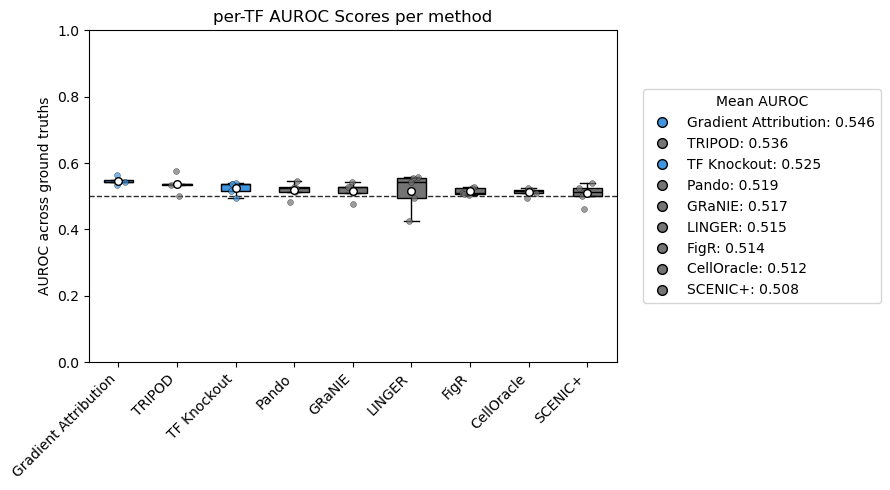

In [33]:
selected_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["experiment"] == selected_experiment].copy()

# Average the per-TF AUROC scores across ground truths for each method
per_tf_mean_across_gt = (
    selected_per_tf_df
    .dropna(subset=["auroc"])
    .groupby(["method", "gt"], as_index=False)
    .agg(
        auroc=("auroc", "mean"),
        n_gt=("gt", "nunique"),
    )
)

plot_all_results_auroc_boxplot(
    per_tf_mean_across_gt, 
    per_tf=True,
    ylim=(0.0, 1.0)
    )
plt.show()

#### Per-TF, aggregated across all TFs

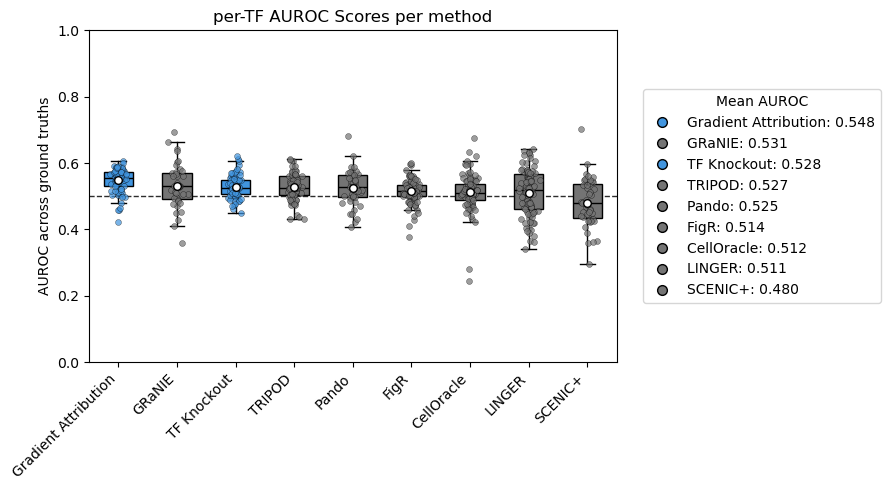

In [34]:
selected_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["experiment"] == selected_experiment].copy()

per_tf_mean_across_tfs = (
    selected_per_tf_df.dropna(subset=["auroc"])
    .groupby(['method', 'tf'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        n_gt=('gt', 'nunique'),
    )
)
plot_all_results_auroc_boxplot(
    per_tf_mean_across_tfs, 
    per_tf=True,
    ylim=(0.0, 1.0)
    )
plt.show()

#### Pooled AUROC scores per ground truth

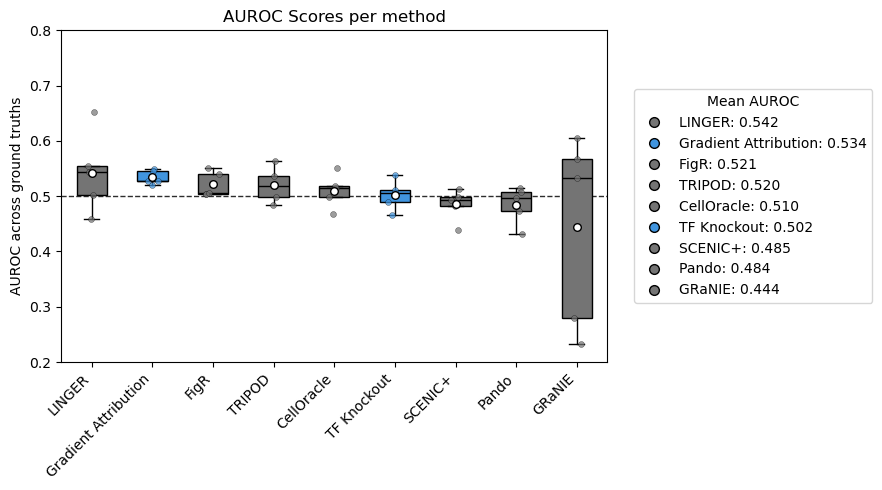

In [35]:
selected_pooled_df = combined_results_df.loc[combined_results_df["experiment"] == selected_experiment].copy()
plot_all_results_auroc_boxplot(
    selected_pooled_df, 
    per_tf=False,
    ylim=(0.2, 0.8)
    )
plt.show()

## Multiple Experiment Plotting

### Plot AUROC scores for multiple experiments

In [154]:
# Select only one method
selected_method = "TF Knockout"

Format the experiment names for the dispersion experiments

In [138]:
def format_experiment_type_names(experiment_type, combined_results_df, combined_per_tf_all_df):
    if experiment_type == "mESC_sample_num":
        multi_sample_results_df = combined_results_df.loc[combined_results_df["method"] == selected_method].copy()
        multi_sample_results_df["method"] = multi_sample_results_df["experiment"].str.replace(r"mESC_", "").str.replace(r"_samples*", " Samples", regex=True).str.replace(r"_hvg_filter_disp_0.01", "", regex=True)

        multi_sample_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["method"] == selected_method].copy()
        multi_sample_per_tf_df["method"] = multi_sample_per_tf_df["experiment"].str.replace(r"mESC_", "").str.replace(r"_samples*", " Samples", regex=True).str.replace(r"_hvg_filter_disp_0.01", "", regex=True)
        
        return multi_sample_results_df, multi_sample_per_tf_df
    
    if experiment_type == "mESC_dispersion":
        dispersion_results_df = combined_results_df.loc[combined_results_df["method"] == selected_method].copy()
        dispersion_results_df["method"] = dispersion_results_df["experiment"].str.replace(r".*hvg_filter_disp_", "Dispersion ", regex=True)

        dispersion_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["method"] == selected_method].copy()
        dispersion_per_tf_df["method"] = dispersion_per_tf_df["experiment"].str.replace(r".*hvg_filter_disp_", "Dispersion ", regex=True)
        
        return dispersion_results_df, dispersion_per_tf_df
    
    elif experiment_type == "macrophage_sample_num":
        multi_sample_results_df = combined_results_df.loc[combined_results_df["method"] == selected_method].copy()
        multi_sample_results_df["method"] = multi_sample_results_df["experiment"].str.replace(r"Macrophage_buffer_", "Samples ", regex=True).str.replace(r"_hvg_filter_disp_0.1", "", regex=True)

        multi_sample_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["method"] == selected_method].copy()
        multi_sample_per_tf_df["method"] = multi_sample_per_tf_df["experiment"].str.replace(r"Macrophage_buffer_", "Samples ", regex=True).str.replace(r"_hvg_filter_disp_0.1", "", regex=True)
        
        return multi_sample_results_df, multi_sample_per_tf_df
    
    elif experiment_type == "macrophage_dispersion":
        macrophage_results_df = combined_results_df.loc[combined_results_df["method"] == selected_method].copy()
        macrophage_results_df["method"] = macrophage_results_df["experiment"].str.replace(r".*_hvg_filter_disp_", "Dispersion ", regex=True)
        macrophage_results_df["method"] = macrophage_results_df["method"].str.replace(r".*_hvg_filter_.*", "Dispersion None", regex=True)


        macrophage_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["method"] == selected_method].copy()
        macrophage_per_tf_df["method"] = macrophage_per_tf_df["experiment"].str.replace(r".*_hvg_filter_disp_", "Dispersion ", regex=True)
        macrophage_per_tf_df["method"] = macrophage_per_tf_df["method"].str.replace(r".*_hvg_filter_.*", "Dispersion None", regex=True)
        
        return macrophage_results_df, macrophage_per_tf_df
    
    elif experiment_type == "k562_dispersion":
        k562_results_df = combined_results_df.loc[combined_results_df["method"] == selected_method].copy()
        k562_results_df["method"] = k562_results_df["experiment"].str.replace(r"K562_hvg_filter_disp_", "Dispersion ", regex=True)
        k562_results_df["method"] = k562_results_df["method"].str.replace(r".*_hvg_filter_.*", "Dispersion None", regex=True)

        k562_per_tf_df = combined_per_tf_all_df.loc[combined_per_tf_all_df["method"] == selected_method].copy()
        k562_per_tf_df["method"] = k562_per_tf_df["experiment"].str.replace(r"K562_hvg_filter_disp_", "Dispersion ", regex=True)
        k562_per_tf_df["method"] = k562_per_tf_df["method"].str.replace(r".*_hvg_filter_.*", "Dispersion None", regex=True)
        
        return k562_results_df, k562_per_tf_df
    else:
        raise ValueError(f"Unsupported experiment type: {experiment_type}. Choose from ['mESC_sample_num', 'mESC_dispersion', 'macrophage_sample_num', 'k562_dispersion']")

### K562 Dispersion

In [73]:
results_df, per_tf_df = format_experiment_type_names("k562_dispersion", combined_results_df, combined_per_tf_all_df)

#### mESC Multiple Samples

In [89]:
results_df, per_tf_df = format_experiment_type_names("mESC_sample_num", combined_results_df, combined_per_tf_all_df)

#### mESC Dispersion

In [116]:
results_df, per_tf_df = format_experiment_type_names("mESC_dispersion", combined_results_df, combined_per_tf_all_df)

#### Macrophage Multiple Samples

In [135]:
results_df, per_tf_df = format_experiment_type_names("macrophage_sample_num", combined_results_df, combined_per_tf_all_df)

#### Macrophage Dispersion

In [155]:
results_df, per_tf_df = format_experiment_type_names("macrophage_dispersion", combined_results_df, combined_per_tf_all_df)

#### Per-TF, aggregated across all ground truths

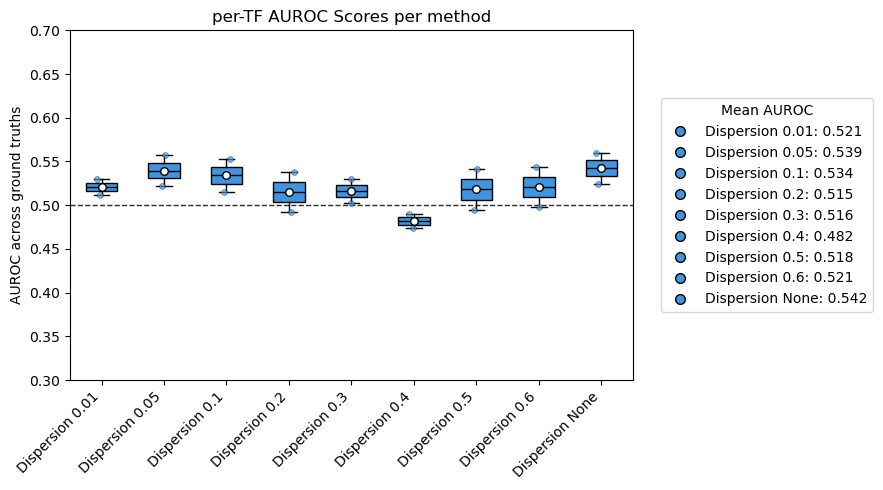

In [156]:
per_tf_mean_across_gt = (
    per_tf_df
    .dropna(subset=["auroc"])
    .groupby(["method", "gt"], as_index=False)
    .agg(
        auroc=("auroc", "mean"),
        n_gt=("gt", "nunique"),
    )
)
plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True, override_color=True, sort_by_mean=False)
plt.show()

#### Per-TF, aggregated across all TFs

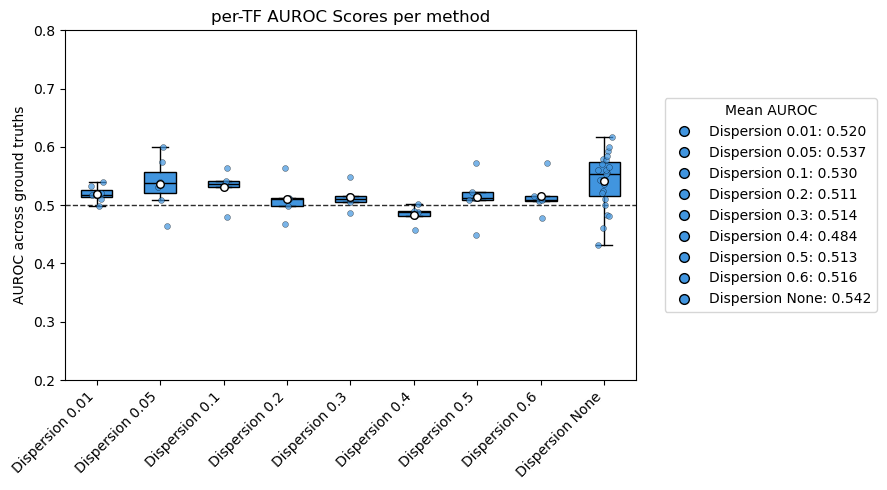

In [157]:
plot_all_results_auroc_boxplot(
    per_tf_df,
    per_tf=True,
    override_color=True,
    sort_by_mean=False,
    ylim=(0.2, 0.8)
    )
plt.show()

#### Pooled AUROC scores per ground truth

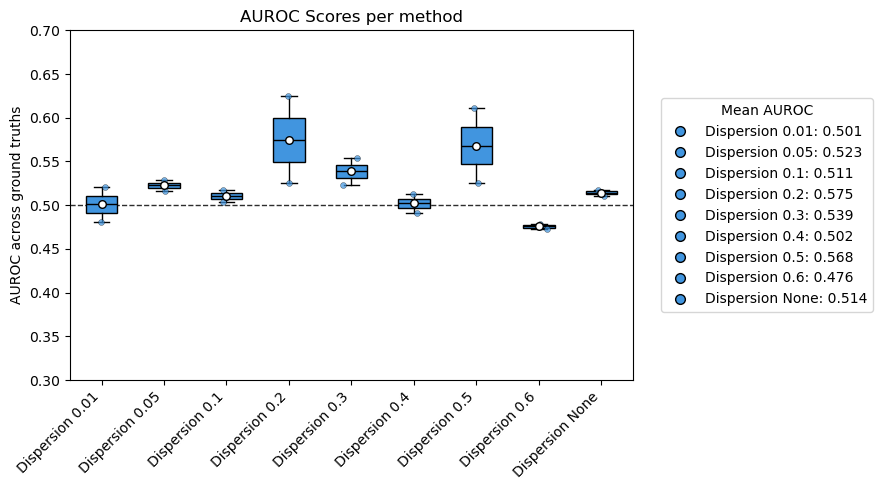

In [158]:
plot_all_results_auroc_boxplot(
    results_df,
    per_tf=False,
    override_color=True,
    sort_by_mean=False,
    )
plt.show()

In [ ]:
combined_results_df.head()

,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%,experiment
0,CellOracle,ChIP-Atlas,0.488130,0.488092,0.5,0.976185,0.448980,0.897959,0.449393,0.898785,0.478788,0.957576,0.463651,0.927302,mESC_E7.5_rep2_hvg_filter_only_rna
1,CellOracle,RN111,0.503192,0.505258,0.5,1.010516,0.517647,1.035294,0.548235,1.096471,0.542353,1.084706,0.517996,1.035992,mESC_E7.5_rep2_hvg_filter_only_rna
2,CellOracle,RN112,0.509338,0.510172,0.5,1.020344,1.000000,2.000000,0.461538,0.923077,0.461538,0.923077,0.488722,0.977444,mESC_E7.5_rep2_hvg_filter_only_rna
3,CellOracle,RN114,0.458157,0.465694,0.5,0.931388,0.111111,0.222222,0.247312,0.494624,0.331551,0.663102,0.423693,0.847385,mESC_E7.5_rep2_hvg_filter_only_rna
4,CellOracle,RN116,0.494700,0.499719,0.5,0.999439,1.000000,2.000000,1.000000,2.000000,0.714286,1.428571,0.400000,0.800000,mESC_E7.5_rep2_hvg_filter_only_rna


## Working on ExperimentLoader

In [1]:
import sys, json, os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset_refactor import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers
import multiomic_transformer.utils.experiment_loader as experiment_loader

In [6]:
from importlib import reload

reload(experiment_loader)

<module 'multiomic_transformer.utils.experiment_loader' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py'>

In [7]:
def plot_true_vs_predicted_tg_expression(prediction_df):
    fig, ax = plt.subplots(figsize=(5,5))

    x = prediction_df["mean_expr_true"]
    y = prediction_df["mean_expr_pred"]

    ax.scatter(x, y, s=10, alpha=0.6)

    lims = [
        min(x.min(), y.min()),
        max(x.max(), y.max()),
    ]

    ax.plot(lims, lims, color="grey", linestyle="--", linewidth=1)

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel("True mean expression")
    ax.set_ylabel("Predicted mean expression")

    plt.show()

In [8]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="mESC_E7.5_rep1_hvg_filter_disp_0.5",
    model_num=1,
)

exp.load_trained_model("trained_model.pt")

In [9]:
experiment_settings = exp.experiment_settings_df
experiment_settings

,parameter,value
0,EXPERIMENT_NAME,E7.5_rep1_hvg_filter_disp_0.5
1,DATASET_NAME,mESC_E7.5_rep1_hvg_filter_disp_0.5
2,ORGANISM_CODE,mm10
3,CHROM_ID,NaN
4,SAMPLE_NAMES,E7.5_rep1
...,...,...
60,SHORTCUT_TOPK,NaN
61,SHORTCUT_DROPOUT,0.0
62,SUBSAMPLE_SEED,42
63,ALLOWED_SAMPLES,NaN


In [10]:
grad_df = exp.load_gradient_attribution()
grad_df

,Source,Target,Score_pooled,Score_per_tf
0,AHR,0610009E02RIK,0.000041,41.178200
1,AHR,1110046J04RIK,0.000449,448.683289
2,AHR,1500015A07RIK,0.000379,379.052246
3,AHR,1600002D24RIK,0.000050,50.446785
4,AHR,1600010M07RIK,0.000975,975.512207
...,...,...,...,...
659707,ZIC2,ZHX2,0.000328,327.988434
659708,ZIC2,ZIC2,0.004502,4511.647949
659709,ZIC2,ZMAT4,0.000018,17.721897
659710,ZIC2,ZSWIM5,0.000148,148.305374


In [11]:
tf_ko_df = exp.load_tf_knockout()
tf_ko_df

,Source,Target,Score_pooled,Score_per_tf,counts
0,AHR,0610009E02RIK,0.000022,1.343177,17
1,AHR,1110046J04RIK,0.000000,-0.899147,18
2,AHR,1500015A07RIK,0.000115,10.710886,17
3,AHR,1600002D24RIK,0.000032,2.314384,17
4,AHR,1600010M07RIK,0.000000,-0.899147,18
...,...,...,...,...,...
659707,ZIC2,ZHX2,0.000074,5.309584,17
659708,ZIC2,ZIC2,0.001204,100.624687,17
659709,ZIC2,ZMAT4,0.000000,-0.915725,18
659710,ZIC2,ZSWIM5,0.000031,1.728154,17


IndexError: tuple index out of range

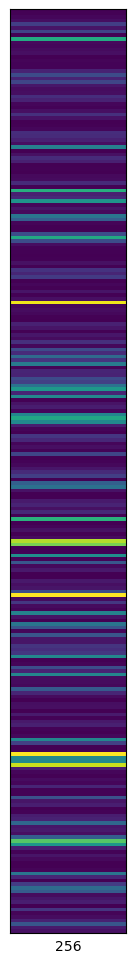

In [ ]:
first_batch = next(iter(exp.test_loader))
atac_wins, tf_tensor, tg_expr_true, bias, tf_ids, tg_ids, motif_mask = first_batch

vec = tf_tensor[0].cpu().numpy()

plt.figure(figsize=(1.5, 12))
plt.imshow(vec.reshape(-1, 1), cmap="viridis", aspect="auto")
plt.xticks([])
plt.yticks([])
plt.xlabel(vec.shape[1])
plt.ylabel("1", fontsize=16)


In [12]:
tg_expr_pred_df, tg_expr_true_df = exp.run_forward_pass(num_batches=15)

predicted_expr = tg_expr_pred_df.copy()
predicted_expr["mean_expr"] = predicted_expr.mean(axis=1).values
predicted_expr["std_expr"] = predicted_expr.std(axis=1).values
predicted_expr = predicted_expr[["mean_expr", "std_expr"]]

true_expr = tg_expr_true_df
true_expr["mean_expr"] = true_expr.mean(axis=1).values
true_expr["std_expr"] = true_expr.std(axis=1).values
true_expr = true_expr[["mean_expr", "std_expr"]]

merged = predicted_expr.merge(
    true_expr,
    left_index=True,
    right_index=True,
    suffixes=("_pred", "_true")
)

merged["diff"] = merged["mean_expr_pred"] - merged["mean_expr_true"]

merged

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
1700034P13RIK,0.224514,0.053713,0.229433,0.006897,-0.004919
CRACDL,-0.003422,0.009388,0.008307,0.000465,-0.011730
CCDC121,0.036170,0.017280,0.021289,0.000409,0.014881
4933439K11RIK,0.079298,0.029692,0.062824,0.001391,0.016474
A830018L16RIK,0.213199,0.068096,0.214371,0.044701,-0.001172
...,...,...,...,...,...
VIL1,0.141707,0.060054,0.199407,0.027805,-0.057700
WNT6,0.153128,0.069239,0.121878,0.019084,0.031250
XKR4,0.556517,0.127558,0.490631,0.127374,0.065886
XPR1,0.461125,0.074698,0.607993,0.083290,-0.146867


In [13]:
param_by_name = dict(exp.model.named_parameters())
for key in param_by_name:
    print(key)

tf_identity_emb.weight
tg_query_emb.weight
tg_identity_emb.weight
tf_expr_dense_input_layer.0.weight
tf_expr_dense_input_layer.0.bias
tf_expr_dense_input_layer.3.weight
tf_expr_dense_input_layer.4.weight
tf_expr_dense_input_layer.4.bias
atac_acc_dense_input_layer.0.weight
atac_acc_dense_input_layer.0.bias
atac_acc_dense_input_layer.3.weight
atac_acc_dense_input_layer.4.weight
atac_acc_dense_input_layer.4.bias
encoder.layers.0.self_attn.in_proj_weight
encoder.layers.0.self_attn.in_proj_bias
encoder.layers.0.self_attn.out_proj.weight
encoder.layers.0.self_attn.out_proj.bias
encoder.layers.0.linear1.weight
encoder.layers.0.linear1.bias
encoder.layers.0.linear2.weight
encoder.layers.0.linear2.bias
encoder.layers.0.norm1.weight
encoder.layers.0.norm1.bias
encoder.layers.0.norm2.weight
encoder.layers.0.norm2.bias
encoder.layers.1.self_attn.in_proj_weight
encoder.layers.1.self_attn.in_proj_bias
encoder.layers.1.self_attn.out_proj.weight
encoder.layers.1.self_attn.out_proj.bias
encoder.layers.

In [ ]:
from pathlib import Path
from typing import Iterator, Tuple, Optional, List
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from typing import Tuple
from pathlib import Path
import math

def tanh_scaled_figsize(rows: int, cols: int, short_in: float = 3.0,
                        max_ratio: float = 5.0, alpha: float = 0.85):
    """
    Returns (fig_w, fig_h) such that:
      - the shorter side is `short_in` inches
      - the longer side grows with tanh(log(raw_ratio)) up to `max_ratio` times longer
      - preserves whether the matrix is tall or wide
    """
    if rows <= 0 or cols <= 0:
        return (short_in, short_in)

    raw_ratio = max(rows, cols) / max(1, min(rows, cols))  # >= 1

    # 1 .. max_ratio (smoothly saturating)
    scaled_ratio = 1.0 + (max_ratio - 1.0) * math.tanh(alpha * math.log(raw_ratio))

    if rows >= cols:
        fig_w = short_in
        fig_h = short_in * scaled_ratio
    else:
        fig_w = short_in * scaled_ratio
        fig_h = short_in

    return fig_w, fig_h

def downsample_2d_mean(data: np.ndarray, max_rows=1500, max_cols=1500):
    r, c = data.shape
    row_bin = max(1, int(np.ceil(r / max_rows)))
    col_bin = max(1, int(np.ceil(c / max_cols)))

    r2 = (r // row_bin) * row_bin
    c2 = (c // col_bin) * col_bin
    data = data[:r2, :c2]

    data = data.reshape(r2 // row_bin, row_bin, c2 // col_bin, col_bin).mean(axis=(1, 3))
    return data, row_bin, col_bin

def save_heatmap_svg_rasterized_downsampled(
    weight_tensor: torch.Tensor,
    out_path: Tuple[str, Path],
    title: str = "",
    cmap: str = "viridis",
    short_in: float = 3.0,
    max_ratio: float = 5.0,
    alpha: float = 0.85,
    dpi: int = 200,
    rasterize: bool = True,   # keep SVG small
    vmin=None,
    vmax=None,
):
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    data = weight_tensor.detach().cpu().numpy()
    if data.ndim != 2:
        data = np.asarray(data).reshape(data.shape[0], -1)

    rows, cols = data.shape
    
    
    fig_w, fig_h = tanh_scaled_figsize(rows, cols, short_in=short_in, max_ratio=max_ratio, alpha=alpha)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    sns.heatmap(
        data,
        cmap=cmap,
        xticklabels=False,
        yticklabels=False,
        cbar=False,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
    )

    # Keep the heatmap itself rasterized inside the SVG so it doesn't become huge
    if rasterize and ax.collections:
        ax.collections[0].set_rasterized(True)

    title = title.replace("_", " ")

    
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(f"{cols}", fontsize=32)
    ax.set_ylabel(f"{rows}", fontsize=32)

    fig.tight_layout(pad=0.15)
    fig.savefig(out_path, format=out_path.suffix.lstrip("."), dpi=dpi, bbox_inches="tight")
    plt.close(fig)


def iter_weight_matrices(model: torch.nn.Module) -> Iterator[Tuple[str, torch.Tensor]]:
    """
    Yields (name, weight_tensor) for 2D weight-like tensors.
    Embeddings are treated as 2D weights too.
    """
    for name, param in model.named_parameters():
        if not isinstance(param, torch.Tensor):
            continue
        if param.ndim == 2:
            yield name, param.detach()
        # If you ever want to include 1D params (bias, layernorm), handle separately.


def split_in_proj_weight_qkv(
    in_proj_weight: torch.Tensor,
    d_model: Optional[int] = None,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Split PyTorch MultiheadAttention in_proj_weight into (Wq, Wk, Wv).
    in_proj_weight shape: (3*d_model, d_model)
    """
    if in_proj_weight.ndim != 2:
        raise ValueError(f"in_proj_weight must be 2D, got {in_proj_weight.shape}")

    rows, cols = in_proj_weight.shape
    if d_model is None:
        d_model = cols

    if rows != 3 * d_model:
        raise ValueError(
            f"Expected in_proj_weight shape (3*d_model, d_model) = ({3*d_model}, {d_model}), "
            f"got {in_proj_weight.shape}"
        )

    Wq = in_proj_weight[0:d_model, :]
    Wk = in_proj_weight[d_model:2*d_model, :]
    Wv = in_proj_weight[2*d_model:3*d_model, :]
    return Wq, Wk, Wv


def save_model_weight_heatmaps(
    model: torch.nn.Module,
    out_dir: Tuple[str, Path],
    include: Optional[List[str]] = None,   # OR logic
    exclude: Optional[List[str]] = None,   # drop if any match
    cmap: str = "viridis",
    max_rows: int = 1500,
    max_cols: int = 1500,
    dpi: int = 200,
    short_in: float = 3.0,
    max_ratio: float = 5.0,
    alpha: float = 0.85,
    split_qkv: bool = True,               # <-- NEW
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    saved = 0

    for name, w in iter_weight_matrices(model):
        # include/exclude filters
        if include is not None and not any(s in name for s in include):
            continue
        if exclude is not None and any(s in name for s in exclude):
            continue

        # ---- Special case: split encoder self-attn packed QKV ----
        # Typical names:
        #   encoder.layers.0.self_attn.in_proj_weight
        #   encoder.layers.1.self_attn.in_proj_weight
        if split_qkv and name.endswith("self_attn.in_proj_weight"):
            d_model = w.shape[1]  # cols
            Wq, Wk, Wv = split_in_proj_weight_qkv(w, d_model=d_model)

            for tag, mat in [("Q", Wq), ("K", Wk), ("V", Wv)]:
                safe_name = name.replace("/", "_") + f"_{tag}"
                out_path = out_dir / f"{safe_name}.svg"
                save_heatmap_svg_rasterized_downsampled(
                    mat,
                    out_path=out_path,
                    title=f"{name} [{tag}]",
                    cmap=cmap,
                    short_in=short_in,
                    max_ratio=max_ratio,
                    alpha=alpha,
                    dpi=dpi,
                    # max_rows=max_rows,
                    # max_cols=max_cols,
                )
                saved += 1

            continue  # don't save the combined packed matrix unless you also want it
        
        else:
            # ---- Default: save weight as-is ----
            safe_name = name.replace("/", "_")
            out_path = out_dir / f"{safe_name}.svg"
            save_heatmap_svg_rasterized_downsampled(
                w,
                out_path=out_path,
                title=name,
                cmap=cmap,
                short_in=short_in,
                max_ratio=max_ratio,
                alpha=alpha,
                dpi=dpi,
                # max_rows=max_rows,
                # max_cols=max_cols,
            )
        saved += 1

    print(f"Saved {saved} heatmaps to: {out_dir}")


# ------------------------- usage -------------------------
save_model_weight_heatmaps(
    exp.model,
    "./dev/model_heatmaps_svg",
    split_qkv=True,
)



Saved 41 heatmaps to: dev/model_heatmaps_svg


In [ ]:
exp.model

MultiomicTransformer(
  (tf_identity_emb): Embedding(256, 128)
  (tg_query_emb): Embedding(25090, 128)
  (tg_identity_emb): Embedding(25090, 128)
  (tf_expr_dense_input_layer): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=False)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (atac_acc_dense_input_layer): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=False)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (posenc): PositionalEmbedding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
 

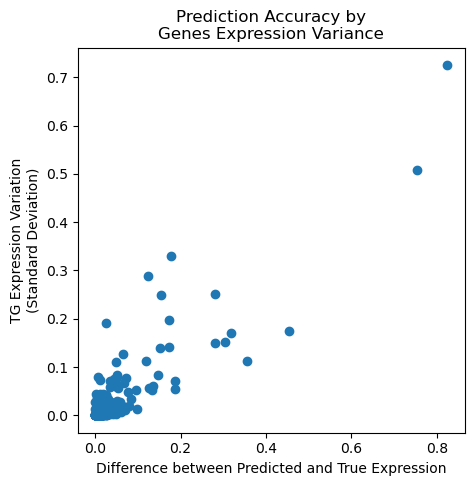

In [ ]:
fig = plt.figure(figsize=(5,5))

plt.scatter(np.abs(merged["diff"]), merged["std_expr_true"])
plt.title("Prediction Accuracy by\nGenes Expression Variance")
plt.xlabel("Difference between Predicted and True Expression")
plt.ylabel("TG Expression Variation\n(Standard Deviation)")
plt.show()

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Range1d, ColumnDataSource, HoverTool

output_notebook()

# Make sure gene names are in a column (NOT just the pandas index)
merged2 = merged.reset_index().rename(columns={"index": "gene"})
merged2["diff"] = np.abs(merged2["diff"])
source = ColumnDataSource(merged2)

lo = float(min(merged2["mean_expr_pred"].min(), merged2["mean_expr_true"].min()))
hi = float(max(merged2["mean_expr_pred"].max(), merged2["mean_expr_true"].max()))

p = figure(
    width=400,
    height=400,
    tools="pan,wheel_zoom,reset",
    x_axis_label="Predicted TG Expression",
    y_axis_label="True TG Expression",
)

scatter_renderer = p.scatter(
    x="mean_expr_pred",
    y="mean_expr_true",
    source=source,
    size=6,
    alpha=0.7
)

# Add hover with your tooltips
hover = HoverTool(
    renderers=[scatter_renderer],   # <<< restrict hover here
    tooltips=[
        ("Gene", "@gene"),
        ("Pred", "@mean_expr_pred{0.000}"),
        ("True", "@mean_expr_true{0.000}"),
    ],
)
p.add_tools(hover)

p.line([lo, hi], [lo, hi])  # 1:1 line

pad = 0.15 * (hi - lo)
p.x_range = Range1d(lo, hi, bounds=(lo - pad, hi + pad))
p.y_range = Range1d(lo, hi, bounds=(lo - pad, hi + pad))

show(p)


Loading BokehJS ...